In [122]:
import time
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter


In [3]:
import os
import pickle as pkl

import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors

from scipy.stats import pearsonr

In [4]:
import torch
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.tvae_util import *

from sklearn.decomposition import PCA

In [37]:
import peptides
import math

In [6]:
def make_model_name(_prop, model_number, semi_sup_percent):
    
    if   _prop == "bch":
        prop="bch"
    elif _prop in ["bc", "boman-chargepH7p2"]:
        prop="boman-chargepH7p2"
    elif _prop in ["b","boman"]:
        prop="boman"
    elif _prop in ["c", "chargepH7p2"]:
        prop="chargepH7p2"
    elif _prop in ["h", "hydrophobicity"]:
        prop="hydrophobicity"
    elif _prop == "predicted-log10mic":
        prop = "predicted-log10mic"
    
    if (semi_sup_percent==100 or semi_sup_percent=="100"):
        percent = ""
        suffix="dPP64-ZScore"
    elif (semi_sup_percent==0 or semi_sup_percent=="0"):
        if prop=="predicted-log10mic":
            percent = "0-"
        else:
            percent = ""
        suffix="cdhit90-zScoreNormalized"
    else:
        percent = str(semi_sup_percent)+"-"
        suffix="cdhit90-zScoreNormalized"

    model_name=f"transvae-64-peptides-{prop}-zScoreNormalized-{percent}organized-{suffix}"

    return model_name

In [69]:
def get_top_2_most_correlated_PCs(df, property_col, return_pcs=True):

    _prop_values = df[property_col].values

    pcs_and_corrs = []
    for _col in df.columns:
        if _col.startswith("pc"):
            if np.sum(np.isnan(_prop_values))>0 :
                _nan_mask = ~np.isnan(_prop_values)
                correl = pearsonr(df[_col].values[_nan_mask], _prop_values[_nan_mask])
            else:
                correl = pearsonr(df[_col].values, _prop_values)
            
            pcs_and_corrs.append( (_col, abs(correl.statistic)) )

    pcs_and_corrs = sorted(pcs_and_corrs, key= lambda x: x[1], reverse=True)

    if return_pcs:
        return pcs_and_corrs[0][0], pcs_and_corrs[1][0] 
    else:
        return pcs_and_corrs

In [136]:
from matplotlib.transforms import Bbox

def points_to_data(ax, dx_pt=0, dy_pt=0):
    """Convert a (dx, dy) in points to data-unit offsets."""
    fig = ax.figure
    # points → pixels
    dx_px, dy_px = dx_pt * fig.dpi / 72.0, dy_pt * fig.dpi / 72.0
    # pixels → data
    x0, y0 = ax.transData.inverted().transform((0, 0))
    x1, y1 = ax.transData.inverted().transform((dx_px, dy_px))
    return (x1 - x0), (y1 - y0)

def text_bbox_in_data(ax, text, pad_pt=0):
    """Return (x0,x1,y0,y1) of a Text's bbox in data units, padding in points."""
    fig = ax.figure
    fig.canvas.draw()  # ensure layout is computed
    r = fig.canvas.get_renderer()
    bb = text.get_window_extent(renderer=r)          # bbox in display/pixels
    if pad_pt:
        # expand bbox by pad_pt on left/right only (horiz); keep vertical same
        pad_px = pad_pt * fig.dpi / 72.0
        bb = Bbox.from_bounds(bb.x0 - pad_px, bb.y0, bb.width + 2*pad_px, bb.height)
    bb_data = bb.transformed(ax.transData.inverted())  # → data coords
    return bb_data.x0, bb_data.x1, bb_data.y0, bb_data.y1

In [16]:
SAVE_FIGURES=False
data_dir="analysis/"
# os.listdir(data_dir)

## get training set embeddings

In [17]:
mu_embedding_files = []
file_to_grab_prefix = "mu_transvae-64"
file_to_grab_suffix = "train.npy"

for _prop in ['boman', 'hydrophobicity', 'chargepH7p2', 'boman-chargepH7p2', 'bch', "predicted-log10mic"]:
    percentages = [0,25,50,75, 98]
    if _prop=="predicted-log10mic":
        percentages = [0, 98]
    for _perc in percentages:
        
        for _d in os.listdir(data_dir):
            
            
            condn_dir = (os.path.isdir(data_dir+_d))
            if _perc==0:
                if _prop=="predicted-log10mic":
                    condn_prefix = (_d.startswith(f"transvae-64-peptides-{_prop}-zScoreNormalized-0-org"))
                else:
                    condn_prefix = (_d.startswith(f"transvae-64-peptides-{_prop}-zScoreNormalized-org"))
            else:
                condn_prefix = (_d.startswith(f"transvae-64-peptides-{_prop}-zScoreNormalized-{_perc}"))
            condn_suffix = (_d.endswith("organized-cdhit90-zScoreNormalized") )
            condn_not = ("--" not in _d)
            
            if condn_dir and condn_prefix and condn_suffix and condn_not:
                print(f"{_d=}")
                for _f in os.listdir(data_dir+_d):
                    if _f.startswith(file_to_grab_prefix) and _f.endswith(file_to_grab_suffix):
                        print(f"{_f=}")
                        mu_embedding_files.append(os.path.join(_d, _f) )
                print()
                

_d='transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-25-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-50-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-50-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-75-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-75-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-boman-zScoreNormalized-98-organized-cdhit90-zScoreNormalized'
_f='mu_transvae-64-peptides-boman-zScoreNormalized-98-organized-cdhit90-zScoreNormalized_train.npy'

_d='transvae-64-peptides-hydrophobicity-zScoreNormalized-organized

In [18]:
latent_spaces = {}
file_to_grab_prefix = "mu_transvae-64"
file_to_grab_suffix = "train.npy"

for _prop in ['boman', 'hydrophobicity', 'chargepH7p2', 'boman-chargepH7p2', 'bch', "predicted-log10mic"]:
    percentages = [0,25,50,75, 98]
    if _prop=="predicted-log10mic":
        percentages = [0, 98]
        
    for _perc in percentages:
        for _dir_file in mu_embedding_files:
            _d, _f = _dir_file.split("/")
            if _perc==0:
                if _prop=="predicted-log10mic":
                    if _d.endswith("zScoreNormalized-0-organized-cdhit90-zScoreNormalized") and (f"peptides-{_prop}-z" in _d ):
                            print(_d)
                            latent_spaces[_prop+"-"+str(_perc)] = np.load(os.path.join(data_dir,_dir_file) )
                else:
                    if _d.endswith("zScoreNormalized-organized-cdhit90-zScoreNormalized") and (f"peptides-{_prop}-z" in _d ):
                        print(_d)
                        latent_spaces[_prop+"-"+str(_perc)] = np.load(os.path.join(data_dir,_dir_file))
            else:
                if (_prop+"-zS" in _d) and (f"-{_perc}-org" in _d):
                    
                    latent_spaces[_prop+"-"+str(_perc)] = np.load(os.path.join(data_dir,_dir_file))


transvae-64-peptides-boman-zScoreNormalized-organized-cdhit90-zScoreNormalized
transvae-64-peptides-hydrophobicity-zScoreNormalized-organized-cdhit90-zScoreNormalized
transvae-64-peptides-chargepH7p2-zScoreNormalized-organized-cdhit90-zScoreNormalized
transvae-64-peptides-boman-chargepH7p2-zScoreNormalized-organized-cdhit90-zScoreNormalized
transvae-64-peptides-bch-zScoreNormalized-organized-cdhit90-zScoreNormalized
transvae-64-peptides-predicted-log10mic-zScoreNormalized-0-organized-cdhit90-zScoreNormalized


In [19]:
latent_spaces.keys()

dict_keys(['boman-0', 'boman-25', 'boman-50', 'boman-75', 'boman-98', 'hydrophobicity-0', 'hydrophobicity-25', 'hydrophobicity-50', 'hydrophobicity-75', 'hydrophobicity-98', 'chargepH7p2-0', 'chargepH7p2-25', 'chargepH7p2-50', 'chargepH7p2-75', 'chargepH7p2-98', 'boman-chargepH7p2-0', 'boman-chargepH7p2-25', 'boman-chargepH7p2-50', 'boman-chargepH7p2-75', 'boman-chargepH7p2-98', 'bch-0', 'bch-25', 'bch-50', 'bch-75', 'bch-98', 'predicted-log10mic-0', 'predicted-log10mic-98'])

## get physico-chemical properties of training set sequences

In [8]:
sequences_train = pd.read_csv("data/peptides_2024_cdhit90_unbalanced_train.txt")
oracle_values_train = pd.read_csv("data/peptides_predicted_log10_mic_train.txt")
bch_properties = pd.read_csv("data/properties/peptides_2024_cdhit90_unbalanced_train_properties_zScoreNormalized.txt")


In [12]:
sequences_train.head()

,peptides
0,CREKA
1,RRWQW
2,RGRGR
3,PRPGP
4,IEFFA


In [13]:
dict_list={
    "aliphatic_index":[],
     # "boman":[],
     "charge_ph3":[],
     # "charge_ph7":[],
     "charge_ph11":[],
    # "hydrophobicity":[],
    "instability_index":[],
    "isoelectric_point":[],
    "molecular_weight":[],
    "sequence_length":[]
}

#calculate physicochemical properties of generated sequences
counter=0
N = len(sequences_train)
for seq in sequences_train.peptides:
    pep = peptides.Peptide(seq)
    dict_list[  "aliphatic_index"].append( pep.aliphatic_index() )
    # dict_list[            "boman"].append( pep.boman() )
    dict_list[       "charge_ph3"].append( pep.charge(pH=3) )
    # dict_list[       "charge_ph7"].append( pep.charge(pH=7) )
    dict_list[      "charge_ph11"].append( pep.charge(pH=11) )
    # dict_list[   "hydrophobicity"].append( pep.hydrophobicity() )
    dict_list["instability_index"].append( pep.instability_index() )
    dict_list["isoelectric_point"].append( pep.isoelectric_point() )
    dict_list[ "molecular_weight"].append( pep.molecular_weight() )
    dict_list[ "sequence_length"].append(  len(seq) )
    
    counter+=1
    if counter%1000==0:
        print(f"done {counter}/{N}")

df = pd.DataFrame(dict_list)
df["boman"] = bch_properties["boman"]
df["charge_ph7"] = bch_properties["charge(pH=7.2)"]
df["hydrophobicity"] = bch_properties['hydrophobicity']
df['oracle'] = oracle_values_train['predicted_mic']
# df.to_csv('data/sampled_physicochem_props.csv',index=False)
# sampled_props = pd.read_csv('data\\sampled_physicochem_props.csv')

done 1000/523848
done 2000/523848
done 3000/523848
done 4000/523848
done 5000/523848
done 6000/523848
done 7000/523848
done 8000/523848
done 9000/523848
done 10000/523848
done 11000/523848
done 12000/523848
done 13000/523848
done 14000/523848
done 15000/523848
done 16000/523848
done 17000/523848
done 18000/523848
done 19000/523848
done 20000/523848
done 21000/523848
done 22000/523848
done 23000/523848
done 24000/523848
done 25000/523848
done 26000/523848
done 27000/523848
done 28000/523848
done 29000/523848
done 30000/523848
done 31000/523848
done 32000/523848
done 33000/523848
done 34000/523848
done 35000/523848
done 36000/523848
done 37000/523848
done 38000/523848
done 39000/523848
done 40000/523848
done 41000/523848
done 42000/523848
done 43000/523848
done 44000/523848
done 45000/523848
done 46000/523848
done 47000/523848
done 48000/523848
done 49000/523848
done 50000/523848
done 51000/523848
done 52000/523848
done 53000/523848
done 54000/523848
done 55000/523848
done 56000/523848
d

In [15]:
df.head()

,aliphatic_index,charge_ph3,charge_ph11,instability_index,isoelectric_point,molecular_weight,sequence_length,boman,charge_ph7,hydrophobicity,oracle
0,20.0,2.126258,-1.730762,8.00,8.545125,605.70994,5,2.758657,-0.024240,-2.009120,2.190306
1,0.0,2.179505,0.982587,237.12,12.500109,830.94734,5,3.849545,0.196433,-4.014466,1.660048
2,0.0,3.179505,1.950536,-25.96,12.801071,600.68154,5,5.880969,0.398120,-4.014466,1.657309
3,0.0,1.179505,0.014639,31.44,10.550002,522.60474,5,1.052996,-0.005255,-2.637661,1.657081
4,98.0,0.126264,-1.953309,95.88,3.849983,625.72214,5,-2.264774,-0.408404,2.779768,1.423120


In [21]:
df.columns

Index(['aliphatic_index', 'charge_ph3', 'charge_ph11', 'instability_index',
       'isoelectric_point', 'molecular_weight', 'sequence_length', 'boman',
       'charge_ph7', 'hydrophobicity', 'oracle'],
      dtype='object')

In [20]:
latent_spaces.keys()

dict_keys(['boman-0', 'boman-25', 'boman-50', 'boman-75', 'boman-98', 'hydrophobicity-0', 'hydrophobicity-25', 'hydrophobicity-50', 'hydrophobicity-75', 'hydrophobicity-98', 'chargepH7p2-0', 'chargepH7p2-25', 'chargepH7p2-50', 'chargepH7p2-75', 'chargepH7p2-98', 'boman-chargepH7p2-0', 'boman-chargepH7p2-25', 'boman-chargepH7p2-50', 'boman-chargepH7p2-75', 'boman-chargepH7p2-98', 'bch-0', 'bch-25', 'bch-50', 'bch-75', 'bch-98', 'predicted-log10mic-0', 'predicted-log10mic-98'])

In [44]:
bvariables = ['aliphatic_index', 'charge_ph3', 'charge_ph11', 'instability_index',
               'isoelectric_point', 'molecular_weight', 'sequence_length', 'boman',
               'charge_ph7', 'hydrophobicity', 'oracle']

In [59]:
df["oracle"]

0         2.190306
1         1.660048
2         1.657309
3         1.657081
4         1.423120
            ...   
523843    1.504001
523844    1.609086
523845    0.770689
523846    1.638756
523847    1.115685
Name: oracle, Length: 523848, dtype: float64

In [155]:
bridge_variable_correlations = {}
bridge_variable_pc = {}

prop_to_colour = {}
prop_to_colour["boman"] = (0,0,0)
prop_to_colour["chargepH7p2"] = (0,158/255,115/255)
prop_to_colour["hydrophobicity"] = (0,114/255, 178/255)
prop_to_colour["boman-chargepH7p2"] = (86/255, 180/255, 233/255)
prop_to_colour["bch"] = (159/255, 74/255, 150/255)
prop_to_colour["predicted-log10mic"] = "C1"

pc_to_colour = {}
pc_to_colour["1"] = "C0"
pc_to_colour["2"] = "C1"
pc_to_colour["3"] = "C2"
pc_to_colour["4"] = "C3"
pc_to_colour["5"] = "C4"

colour_dict = {}
colour_dict_by_pc = {}
for _pc_property in bvariables:
    print(_pc_property)
    data_to_plot = pd.DataFrame()

    for _prop in ['boman', 'hydrophobicity', 'chargepH7p2', 'boman-chargepH7p2', 'bch', "predicted-log10mic"]:
        percentages = [0,25,50,75, 98]
        if _prop=="predicted-log10mic":
            percentages = [0, 98]
            
        for _perc in percentages:
    
            _key = f"{_prop}-{_perc}"
            
            ##############################
            # Perform dimensionality reduction
            # load property data
            # get top two principal components (based on pearson correlation coefficient)
            pca = PCA(n_components=5)
            pca.fit(latent_spaces[_key])
            pca_latent_space = pca.transform(latent_spaces[_key])

            for i in range(pca.n_components):
                df[f'pc{i+1}'] = pca_latent_space[:,i]
            
            _pc1 = get_top_2_most_correlated_PCs(df, _pc_property, return_pcs=False)
            print(f"{_pc_property}-{_key}, {_pc1}")
            bridge_variable_pc[f"{_pc_property}-{_key}"] = _pc1[0][0][-1]
            bridge_variable_correlations[f"{_pc_property}-{_key}"] = _pc1[0][1]
            colour_dict[f"{_pc_property}-{_key}"] = prop_to_colour[_prop]
            colour_dict_by_pc[f"{_pc_property}-{_key}"] = pc_to_colour[_pc1[0][0][-1]]


aliphatic_index
aliphatic_index-boman-0, [('pc3', 0.636218412583008), ('pc2', 0.23869716411734074), ('pc4', 0.12366986567988175), ('pc1', 0.01828589140263598), ('pc5', 0.010782863326870576)]
aliphatic_index-boman-25, [('pc2', 0.4787469001869012), ('pc4', 0.4769720271668997), ('pc3', 0.041848899254551125), ('pc1', 0.014463123785047988), ('pc5', 0.010489534701977868)]
aliphatic_index-boman-50, [('pc3', 0.44724670820082163), ('pc2', 0.2920718004413736), ('pc1', 0.16247194886814043), ('pc4', 0.08922468047756778), ('pc5', 0.05146307645331449)]
aliphatic_index-boman-75, [('pc3', 0.6506280547497005), ('pc5', 0.4776983661796704), ('pc4', 0.08456200537803062), ('pc1', 0.04775132845593494), ('pc2', 0.019829682619476166)]
aliphatic_index-boman-98, [('pc1', 0.5323001687709372), ('pc2', 0.4364725163581322), ('pc4', 0.2456495186212191), ('pc3', 0.17085819885138606), ('pc5', 0.048823412843653755)]
aliphatic_index-hydrophobicity-0, [('pc1', 0.48364655552056035), ('pc5', 0.3331648763591647), ('pc2', 0.

In [156]:
bridge_variable_correlations.keys()

dict_keys(['aliphatic_index-boman-0', 'aliphatic_index-boman-25', 'aliphatic_index-boman-50', 'aliphatic_index-boman-75', 'aliphatic_index-boman-98', 'aliphatic_index-hydrophobicity-0', 'aliphatic_index-hydrophobicity-25', 'aliphatic_index-hydrophobicity-50', 'aliphatic_index-hydrophobicity-75', 'aliphatic_index-hydrophobicity-98', 'aliphatic_index-chargepH7p2-0', 'aliphatic_index-chargepH7p2-25', 'aliphatic_index-chargepH7p2-50', 'aliphatic_index-chargepH7p2-75', 'aliphatic_index-chargepH7p2-98', 'aliphatic_index-boman-chargepH7p2-0', 'aliphatic_index-boman-chargepH7p2-25', 'aliphatic_index-boman-chargepH7p2-50', 'aliphatic_index-boman-chargepH7p2-75', 'aliphatic_index-boman-chargepH7p2-98', 'aliphatic_index-bch-0', 'aliphatic_index-bch-25', 'aliphatic_index-bch-50', 'aliphatic_index-bch-75', 'aliphatic_index-bch-98', 'aliphatic_index-predicted-log10mic-0', 'aliphatic_index-predicted-log10mic-98', 'charge_ph3-boman-0', 'charge_ph3-boman-25', 'charge_ph3-boman-50', 'charge_ph3-boman-75

In [157]:
subpanel_to_letter = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.']

aliphatic_index
charge_ph3
charge_ph11
instability_index
isoelectric_point
molecular_weight
sequence_length
boman
charge_ph7
hydrophobicity
oracle


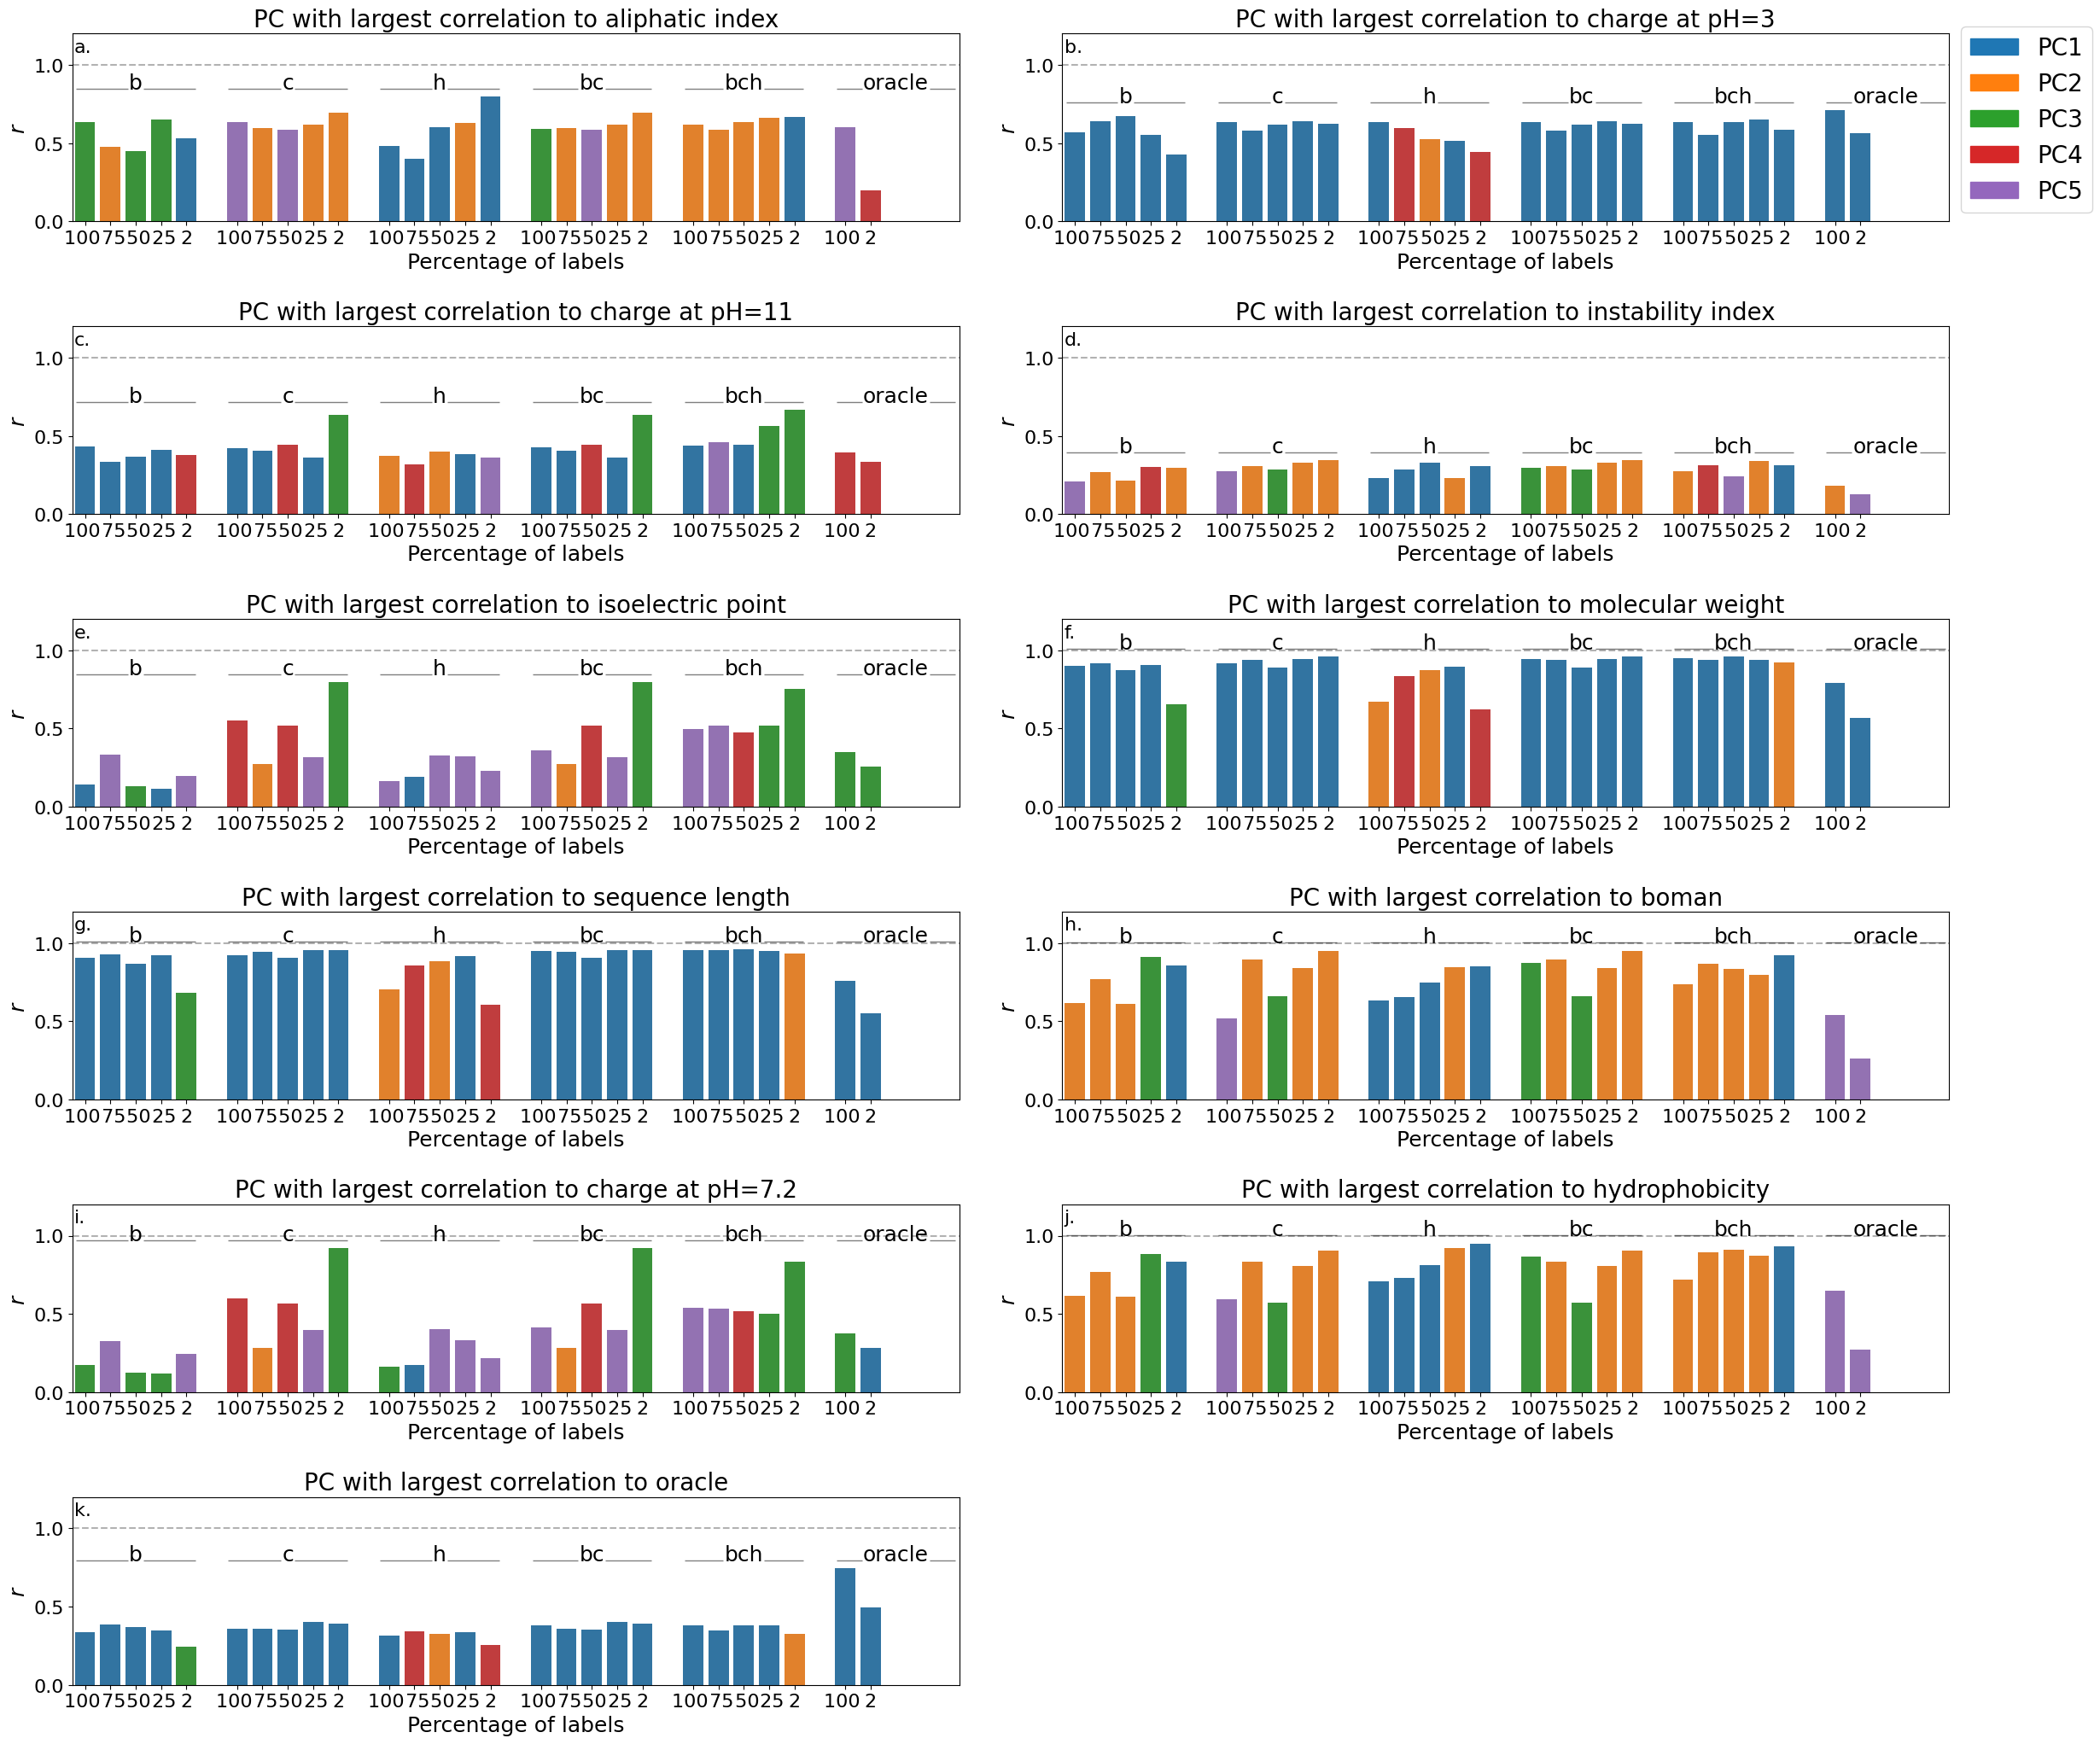

In [171]:
superfig = plt.figure(figsize=(25,20))

properties = ['boman', 'chargepH7p2', 'hydrophobicity', 'boman-chargepH7p2', 'bch', "predicted-log10mic"]

fontsize=20

subfigs = superfig.subfigures(math.ceil(len(bvariables)/2), 2, wspace=-0.135)


for ix, _pc_property in enumerate(bvariables):
    print(_pc_property)
    data_to_plot = pd.DataFrame()

    fig = subfigs.flat[ix]
    ax = fig.add_subplot()
    
    ax.set_ylim([0,1.2])
    _new_xtick_labels = []
    _new_xticks = []
    counter=0
    for i in range(len(properties)):        
        if i<len(properties)-1:        
            _new_xtick_labels += ["100 "," 75"," 50"," 25",2]
            _new_xticks += list(range(counter, counter+5, 1)) 
            counter+= 5
        else:
            _new_xtick_labels += ["100 ",2]
            _new_xticks += list(range(counter, counter+2, 1)) 
            counter+= 2    
        
        if i<len(properties)-1:
            counter += 1
    
    ax.set_xticks(_new_xticks)
    ax.set_xticklabels(
        _new_xtick_labels,
    )

    ####################################################
    ####################################################
    # grab the right data
    for i, _prop in enumerate(properties):
        percentages = [0,25,50,75, 98]
        if _prop in ["predicted-log10mic", "oracle"]:
            percentages = [0, 98]
            
        for _perc in percentages:
            _key=f"{_prop}-{_perc}"
            data_to_plot[f"{_pc_property}-{_key}"] = [ bridge_variable_correlations[f"{_pc_property}-{_key}"] ]
        
        if i<len(properties)-1:
            colour_dict[ f"blank-{_prop}"] = "k"
            colour_dict_by_pc[ f"blank-{_prop}"] = "k"
            data_to_plot[f"blank-{_prop}"] = [0]#[0]*len( percentages )
    
    ####################################################
    ####################################################
    # plot data
    ax = sns.barplot(
        data=data_to_plot, 
        ax=ax, 
        palette=colour_dict_by_pc
        # palette=colour_dict
    )

    ####################################################
    ####################################################
    # Annotate bar groups with text and gray lines
    tallest = max(bar.get_height() for bar in ax.patches)
    for i, _prop in enumerate(properties):
        if _prop in ["boman-chargepH7p2"]:
            _text = "bc"
        elif _prop in ["predicted-log10mic","oracle"]:
            _text="oracle"
        elif _prop=="bch":
            _text="bch"
        else:
            _text = _prop[0]

        _center_pos = 2 + 6*i
        y_line = tallest+0.05
        txt = ax.text(x=_center_pos,
                      y=y_line, 
                      s=_text,
                      horizontalalignment="center",
                      fontsize=16+2
                       # bbox=dict(alpha=0)
        )
        
        # Compute text edges in data coords
        if i in [2]:
            pass
            # _pad_pt = -5
        elif i==0:
            _pad_pt = 3
        else:
            _pad_pt = 1
        x0, x1, y0, y1 = text_bbox_in_data(ax, txt, pad_pt=_pad_pt)   # pad 2 pt around text
        xoff, yoff = points_to_data(ax, dy_pt=0)                    # lift line by 2 pt

        if i!=10:
            # Draw the “rules” that stop at the text edges
            ax.hlines(y_line, xmin=-0.35 + i*6, xmax=x0, linewidth=1.0, color="k", alpha=0.5)      # left segment
            ax.hlines(y_line, xmin=x1, xmax=4.35+ i*6, linewidth=1.0, color="k", alpha=0.5)      # right segment

    ax.hlines(y=1.0, xmin=-0.5, xmax=34.5, color="k", alpha=0.3, linestyle="--", linewidth=1.5)
    ax.set_xlim([-0.5,34.5])
    ax.set_xlabel("Percentage of labels", fontsize=18)
    ax.tick_params(labelsize=16)
    ax.set_ylabel("$r$", fontsize=18)

    ax.annotate(
        subpanel_to_letter[ix],
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.1, -0.25), textcoords='offset fontsize',
        fontsize=16, verticalalignment='top', fontfamily='sans-serif',
        # bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )

    ####################################################
    # Make title
    _title = "PC with largest correlation to "
    if len(_pc_property.split("_"))>1:
        if "charge" in _pc_property:
            _charge_value = _pc_property.split("_")[-1][2:]
            if _charge_value=="7":
                _charge_value = "7.2"
            _suffix =  " ".join( [_pc_property.split("_")[0], f"at pH={_charge_value}"] )
        else:
            _suffix =  " ".join(_pc_property.split("_") )
    else:
        _suffix = _pc_property
    
    ax.set_title(_title+_suffix, fontsize=fontsize)

    
    ####################################################
    # Make legend
    if _pc_property=="charge_ph3": # top right corner
        handles = [
            mpatches.Patch(color=color, label=key)
            for key, color in pc_to_colour.items()
        ]
        ax.legend(
            handles=handles,
            labels=[f"PC{_e}" for _e in list(pc_to_colour.keys())],
            bbox_to_anchor=(1.0,1.1), loc="upper left", fontsize=fontsize
        )


In [174]:
if SAVE_FIGURES:
    superfig.savefig("figures/bridge_variables_bar_plot.pdf",dpi=300,bbox_inches='tight')